# Exclusive Or (XOR) Example

This example shows how to use `pydatapull` to generate noisy variants of the classical exclusive or problem and train a neural network to solve the problem.

Here we require a model $\hat{y} = f(x)$ to fit the function defined by

| $f(x)$ | $x_1$ | $x_2$ |
|:---:|:----:|:----:|
| 0 | 0 | 0 |
| 1 | 0 | 1 |
| 1 | 1 | 0 |
| 0 | 1 | 1 |

The XOR problem is one of the simplest functions which requires deep models to fit, since no model of the form
$$
y = \boldsymbol{w} \cdot \boldsymbol{x} + b
$$
will fit it. Instead, a model of the form
$$
y =  \boldsymbol{w_2}\varphi(\boldsymbol{W_1}\boldsymbol{x} + \boldsymbol{b_1}) + \boldsymbol{b_2}
$$
is required.

## Basic Imports

Here we import some basic tools.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["text.usetex"] = True
plt.rcParams["font.size"] = 14
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

np.random.seed(42)

## Import the Data Loader

Here we import the `generate_xor_dataset` function.

In [2]:
from pydatapull.basicml import generate_xor_dataset

## Load the Data

Now we can use `generate_xor_dataset` to load different variations of the XOR dataset.

In [3]:
n_samples_per_class = 2
sigma = 0
x_features, y_labels, labels = generate_xor_dataset(
    n_samples_per_class, sigma=sigma
)

## Visualize the Data

We can use the `scatter_plot_dataset` function to visualize our data.


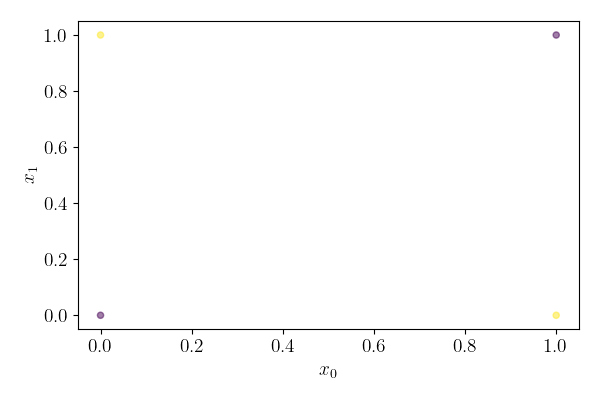

In [4]:
from pydatapull.visualizers import scatter_plot_dataset

_, ax = scatter_plot_dataset(x_features, y_labels)

# Use the handles returned to keep editing the figure, if desired
ax.set_title(f"Noisy XOR, $\\sigma = {sigma}$", usetex=True)
plt.tight_layout()

## Fit a Model

Here we fit a model to our data. First we import torch and perform some basic set up operations. Then we convert our data to a torch tensor, define a model, and train it.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Convert data to a torch tensor; remember to reshape the labels into an
# Nx1 element matrix since this is what pytorch expects.
x_features_tensor = torch.tensor(x_features, dtype=torch.float32)
y_labels_tensor = torch.tensor(y_labels.reshape(-1, 1), dtype=torch.float32)


# Define the model
class XORDemoNet(nn.Module):
    def __init__(self):
        super(XORDemoNet, self).__init__()
        self.lin1 = nn.Linear(2, 2)
        self.lin2 = nn.Linear(2, 1)

        for layer in self.children():
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0.0, std=0.05)

    def forward(self, x):
        x = self.lin1(x)
        x = torch.sigmoid(x)
        x = self.lin2(x)
        x = torch.sigmoid(x)
        return x


# Set parameters
learning_rate = 0.05
number_of_epochs = 500

# Initialize the network
model = XORDemoNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train
for epoch in range(number_of_epochs):
    optimizer.zero_grad()
    output = model(x_features_tensor)
    loss = criterion(output, y_labels_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{number_of_epochs}], Loss: {loss.item():.4f}")

Epoch [100/500], Loss: 0.0271
Epoch [200/500], Loss: 0.0034
Epoch [300/500], Loss: 0.0016
Epoch [400/500], Loss: 0.0010
Epoch [500/500], Loss: 0.0007


## Visualize the Results

For low-dimensional, tabular datasets, we can use `plot_2d_decision_surface_and_features` to visualize what functions our model has learned. This is helpful for getting intuition about how models fit low-dimensional, tabular data.

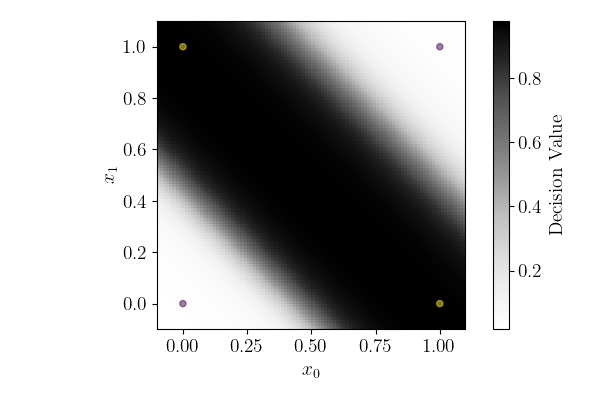

In [7]:
from pydatapull.visualizers import plot_2d_decision_surface_and_features

# Use a lambda to allow the model to make inferences on numpy arrays so it
# meets the signature required by the plot function, i.e.,
# Callable[[np.ndarray], np.ndarray]
forward = (
    lambda x: model.forward(torch.tensor(x, dtype=torch.float32))
    .detach()
    .numpy()
)

with torch.no_grad():
    y_predicted_tensor = model.forward(x_features_tensor)
    y_predicted_category: int = np.round(y_predicted_tensor.detach().numpy())

    _, ax = plot_2d_decision_surface_and_features(
        x_features=x_features,
        y_labels=y_predicted_category,
        plot_function=forward,
        x_range=(-0.1, 1.1),
        y_range=(-0.1, 1.1),
    )
    ax.set_title(f"Noisy XOR Dataset, $\\sigma = {sigma}$", usetex=True)
    plt.tight_layout()

## Generate a Noisy Dataset

Here we change the `sigma` parameter for `generate_xor_dataset` to generate a noisy version of the XOR problem.

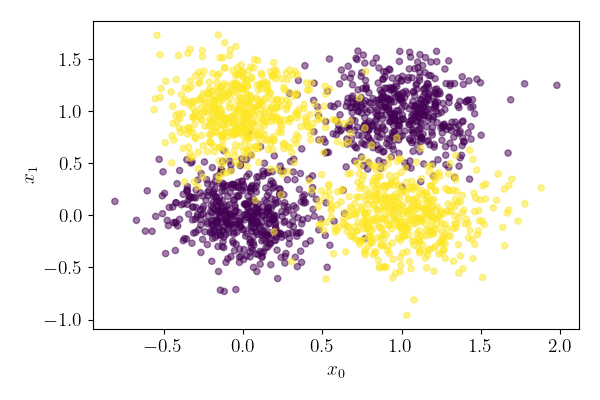

In [8]:
# Generate the data
n_samples_per_class = 1000
sigma = 0.25
x_features_noisy, y_labels_noisy, labels = generate_xor_dataset(
    n_samples_per_class, sigma=sigma
)

# Visualize
_, ax = scatter_plot_dataset(x_features_noisy, y_labels_noisy)
ax.set_title(f"Noisy XOR, $\\sigma = {sigma}$", usetex=True)
plt.tight_layout()

# Convert to tensor
x_features_noisy_tensor = torch.tensor(x_features_noisy, dtype=torch.float32)
y_labels_noisy_tensor = torch.tensor(
    y_labels_noisy.reshape(-1, 1), dtype=torch.float32
)

## Visualize the Model's Predictions

Now we can see how our original model, trained on the noiseless XOR dataset, performs on the noisy data. We see that it lacks sufficient flexibility to fit the curves that are now key to drawing a boundary between the classes. We also see that some points will be fundamentally inseparable, i.e., no matter how good our model is, it will not be able to distinguish them.

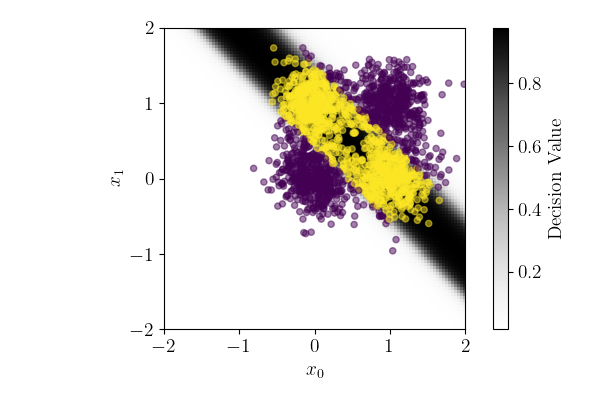

In [9]:
with torch.no_grad():
    y_predicted_noisy_tensor = model.forward(x_features_noisy_tensor)
    y_predicted_noisy_category: int = np.round(
        y_predicted_noisy_tensor.detach().numpy()
    )
    _, ax = plot_2d_decision_surface_and_features(
        x_features=x_features_noisy,
        y_labels=y_predicted_noisy_category,
        plot_function=forward,
        x_range=(-2, 2),
        y_range=(-2, 2),
    )
    ax.set_title(f"Noisy XOR Dataset, $\\sigma = {sigma}$", usetex=True)
    plt.tight_layout()

## Train a Model on Noisy Data

Here we try to train a model on noisy data, to see if we can improve performance by preparing our model to handle noise in the training set.

In [10]:
# Set parameters
learning_rate = 0.01
number_of_epochs = 1000

# Initialize the network
noise_trained_model = XORDemoNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(noise_trained_model.parameters(), lr=learning_rate)

# Train
for epoch in range(number_of_epochs):
    optimizer.zero_grad()
    output = noise_trained_model(x_features_noisy_tensor)
    loss = criterion(output, y_labels_noisy_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{number_of_epochs}], Loss: {loss.item():.4f}")

Epoch [100/1000], Loss: 0.2499
Epoch [200/1000], Loss: 0.2412
Epoch [300/1000], Loss: 0.1898
Epoch [400/1000], Loss: 0.1700
Epoch [500/1000], Loss: 0.1625
Epoch [600/1000], Loss: 0.1586
Epoch [700/1000], Loss: 0.1563
Epoch [800/1000], Loss: 0.1548
Epoch [900/1000], Loss: 0.1537
Epoch [1000/1000], Loss: 0.1530


On inspection of the classification boundary, we can clearly see where the problem is. Even when our model is trained on noisy data, it does not have the ability to draw a classification boundary with sufficient curvature to fit around the clusters that are now widened due to noise.

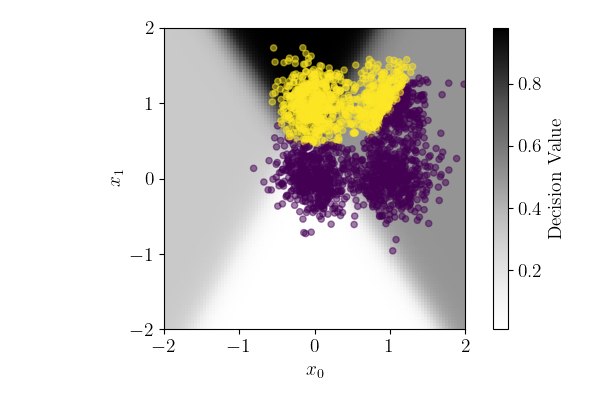

In [11]:
noise_trained_forward = (
    lambda x: noise_trained_model.forward(torch.tensor(x, dtype=torch.float32))
    .detach()
    .numpy()
)

with torch.no_grad():
    y_predicted_noise_trained_model_tensor = noise_trained_model.forward(
        x_features_noisy_tensor
    )
    y_predicted_noise_trained_model_category: int = np.round(
        y_predicted_noise_trained_model_tensor.detach().numpy()
    )
    _, ax = plot_2d_decision_surface_and_features(
        x_features=x_features_noisy,
        y_labels=y_predicted_noise_trained_model_category,
        plot_function=noise_trained_forward,
        x_range=(-2, 2),
        y_range=(-2, 2),
    )
    ax.set_title(f"Noisy XOR Dataset, $\\sigma = {sigma}$", usetex=True)
    plt.tight_layout()

## Train a Higher Capacity Model on Noisy Data

To fit the noisy data, we will need a higher capacity model, i.e., a model with more flexibility in its classification boundary. We can increase model capacity by adding additional parameters. In this case, we increase the number of hidden nodes.

In [12]:
# Define the model
class XORDemoNetHigherCapacity(nn.Module):
    def __init__(self):
        super(XORDemoNetHigherCapacity, self).__init__()
        self.lin1 = nn.Linear(2, 7)
        self.lin2 = nn.Linear(7, 1)

        for layer in self.children():
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0.0, std=0.05)

    def forward(self, x):
        x = self.lin1(x)
        x = torch.sigmoid(x)
        x = self.lin2(x)
        x = torch.sigmoid(x)
        return x


# Set parameters
learning_rate = 0.05
number_of_epochs = 500

# Initialize the network
higher_capacity_model = XORDemoNetHigherCapacity().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(higher_capacity_model.parameters(), lr=learning_rate)

# Train
for epoch in range(number_of_epochs):
    optimizer.zero_grad()
    output = higher_capacity_model(x_features_noisy_tensor)
    loss = criterion(output, y_labels_noisy_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{number_of_epochs}], Loss: {loss.item():.4f}")

Epoch [100/500], Loss: 0.0883
Epoch [200/500], Loss: 0.0787
Epoch [300/500], Loss: 0.0715
Epoch [400/500], Loss: 0.0648
Epoch [500/500], Loss: 0.0616


Now we can see our model has learned a more general classification boundary that is somewhat robust to the noise.

The boundary also leaves a lot to be desired. Note that some points are close to boundaries which are non-intuitive. Applying even small perturbations to some of these points will completely change their classification result.

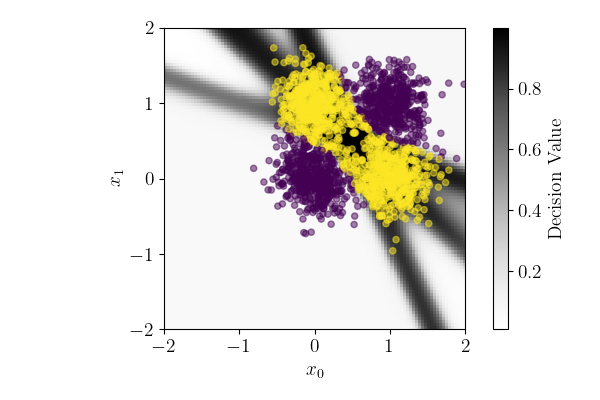

In [13]:
high_capacity_forward = (
    lambda x: higher_capacity_model.forward(
        torch.tensor(x, dtype=torch.float32)
    )
    .detach()
    .numpy()
)

with torch.no_grad():
    y_predicted_high_capacity_tensor = higher_capacity_model.forward(
        x_features_noisy_tensor
    )
    y_predicted_high_capacity_category: int = np.round(
        y_predicted_high_capacity_tensor.detach().numpy()
    )
    _, ax = plot_2d_decision_surface_and_features(
        x_features=x_features_noisy,
        y_labels=y_predicted_high_capacity_category,
        plot_function=high_capacity_forward,
        x_range=(-2, 2),
        y_range=(-2, 2),
    )
    ax.set_title(f"Noisy XOR Dataset, $\\sigma = {sigma}$", usetex=True)
    plt.tight_layout()